### Imports

In [1]:
import os
os.environ["SPS_HOME"] = "/Users/ncv375/Desktop/Year1/spatialSED/quick_repo_natalia/fsps"
import numpy as np
from sbipix import sbipix
from sbipix import *
import pickle
import torch
from scipy import stats
import matplotlib.font_manager as fm
import matplotlib.patches as patches
import matplotlib.ticker as ticker

sx = sbipix()
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


### Set initializations for SBIPIX

Can adjust:
- path where observational properties are stored (e.g. filters, percentiles and corresponding mean & std for each filter, background noise levels per filter)
- name of model as set in training script, and path to where model is stored
- number of galaxies in simulation used to train model
- options about SFH (parametric), both_masses???, whether to infer only redshift, and whether to include observational information about background noise limits

In [2]:
sx.filter_path = './obs/obs_properties/'
sx.load_obs_features()

local_path=os.path.abspath('.')
sx.model_name = 'post_obs_jades_tau_GSz14test.pkl' # Adjust this to your model, this is a model trained on cpu up to z=7.5 with tau-delayed SFHs on 100k simulations
sx.model_path = './library/'
sx.n_simulation = 100000
sx.parametric = True
sx.both_masses = True
sx.infer_z = True
sx.infer_onlyz = True
sx.include_limit = True
sx.condition_sigma = True
sx.include_sigma = True

Observational features loaded


### Open observational data files, and set filter names

In [15]:
phot=np.load('full_phot_test_GSz14_newsbipix.npy',allow_pickle=True)
err=np.load('full_err_test_GSz14_newsbipix.npy',allow_pickle=True)
c_array = np.load('c_arr_test_GSz14_newsbipix.npy',allow_pickle=True)

filters_name=[
    "JWST_NIRCam_F090W",
    "JWST_NIRCam_F115W",
    "JWST_NIRCam_F150W",
    "JWST_NIRCam_F182M",
    "JWST_NIRCam_F200W",
    "JWST_NIRCam_F210M",
    "JWST_NIRCam_F277W",
    "JWST_NIRCam_F335M",
    "JWST_NIRCam_F356W",
    "JWST_NIRCam_F410M",
    "JWST_NIRCam_F430M",
    "JWST_NIRCam_F444W",
    "JWST_NIRCam_F460M",
    "JWST_NIRCam_F480M",
    "HST_ACS.F435W",
    "HST_ACS.F606W",
    "HST_ACS.F775W",
    "HST_ACS.F814W",
    "HST_ACS.F850LP"
]

## Look at photometry first

#### Do SNR cut on photometry and make cutout of designated bounds

In [40]:
def cut_phot(phot=phot, err=err, c_array=c_array, sn_limit=10):
    ''' 
    Do SNR cut on photometry and make cutout of designated bounds

    Inputs:
        phot: 2D array of photometry loaded before [pixels, filters]
        err: 2D array of errors loaded before [pixels, filters]
        c_array: array of coordinates corresponding to each pixel [pixels][y, x]
        sn_limit: SNR lower limit for cut (default is 10)

    Outputs:
        phot_gal: 3D array of photometry cutout [filters, y, x]
        err_gal: 3D array of errors cutout [filters, y, x]
        c_gal: array of coordinates for the cutout (pixels x 2)
        max_sn: mask of pixels above the SNR limit
    '''

    # Designate filters you want to calculate SNR for, and for each pixel, take the mean SNR across those filters
    filters_sn = [6, 8, 11]  # F277W, F356W, F444W
    print(f"Using filters for S/N calculation: {[filters_name[i] for i in filters_sn]}")

    s_n = np.nanmean(phot[:, filters_sn] / err[:, filters_sn], axis=1)
    # SNR cut
    max_sn = np.where(s_n > sn_limit)[0]

    print(f'Minimum S/N = {np.nanmin(s_n[max_sn]):.2f}')
    print(f'Computing posteriors for {len(max_sn)} pixels (S/N > {sn_limit})')
    print(f'Total pixels in galaxy: {len(phot)}')

    if len(max_sn) == 0:
        print(f"ERROR: No pixels above S/N limit {sn_limit}!")

    # Create cutout to store photometry, where all pixels not meeting SNR criteria are kept as NaN
    c_gal = np.array(c_array[0])

    phot_gal = np.empty((len(phot[0]), c_gal[-1][0]+1, c_gal[-1][1]+1))
    phot_gal[:] = np.nan
    err_gal = np.empty((len(phot[0]), c_gal[-1][0]+1, c_gal[-1][1]+1))
    err_gal[:] = np.nan

    # Use coordinates array to organize photometry and errors into the cutout
    c_gal = np.array(c_array[0])
    for k in range(len(c_gal)):
        phot_gal[:, c_gal[k, 0], c_gal[k, 1]] = phot[k, :]
        err_gal[:, c_gal[k, 0], c_gal[k, 1]] = err[k, :]

    return phot_gal, err_gal, c_gal, max_sn

#### Plot photometry and SNR as check

In [86]:
def plot_photerr(phot_gal, err_gal, filters_name=filters_name, size=50):
    '''
    Plot photometry and SNR maps for each filter

    Inputs:
        phot_gal: 3D array of photometry cutout (from cut_phot) [filters, y, x]
        err_gal: 3D array of errors cutout (from cut_phot) [filters, y, x]
        filters_name: list of filter names for titles
        size: size of the cutout to display around the center (default is 50 pixels)

    Outputs:
        None, but displays plots of photometry and SNR for each filter
    '''

    # Center of the cutout, used for plotting
    center_x = len(phot_gal[0, 0, :])//2
    center_y = len(phot_gal[0, :, 0])//2
    print(center_x, center_y)

    # Set bounds for plotting
    bounds_y = [max(center_y-size, 0), min(center_y+size, phot_gal.shape[1])]
    bounds_x = [max(center_x-size, 0), min(center_x+size, phot_gal.shape[2])]

    # loop over filters
    i_filter = range(len(phot[0]))  
    for i in i_filter:
        # try plotting photometry and SNR for the filter, and if there's no data in that region for the filter then an error message is printed
        try:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

            # plot photometry
            im1 = ax1.imshow(phot_gal[i, bounds_y[0]:bounds_y[1], bounds_x[0]:bounds_x[1]], origin='lower', norm='log', cmap='Grays')
            fig.colorbar(im1, ax=ax1, label='$\\mu$Jy')
            ax1.set_title(filters_name[i][-5:])

            # plot SNR
            im2 = ax2.imshow(phot_gal[i, bounds_y[0]:bounds_y[1], bounds_x[0]:bounds_x[1]]/err_gal[i, bounds_y[0]:bounds_y[1], bounds_x[0]:bounds_x[1]], origin='lower', cmap='Grays')
            fig.colorbar(im2, ax=ax2, label='S/N')
            ax2.set_title(filters_name[i][-5:]+' S/N')

            plt.show()
        except:
            print('An error occurred when plotting the photometry for '+filters_name[i][-5:]+', ignoring...')
            pass

In [87]:
phot_gal, err_gal, c_gal, max_sn = cut_phot()

Using filters for S/N calculation: ['JWST_NIRCam_F277W', 'JWST_NIRCam_F356W', 'JWST_NIRCam_F444W']
Minimum S/N = 10.01
Computing posteriors for 300 pixels (S/N > 10)
Total pixels in galaxy: 21450


97 55


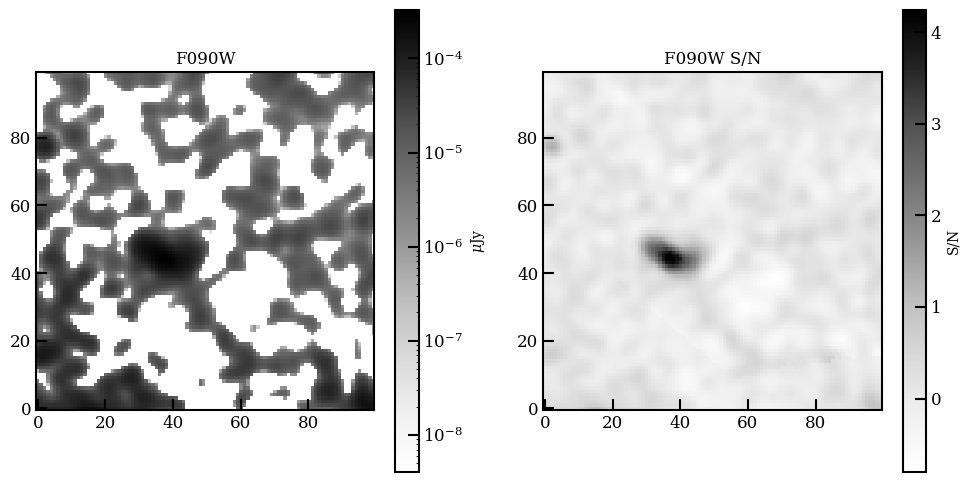

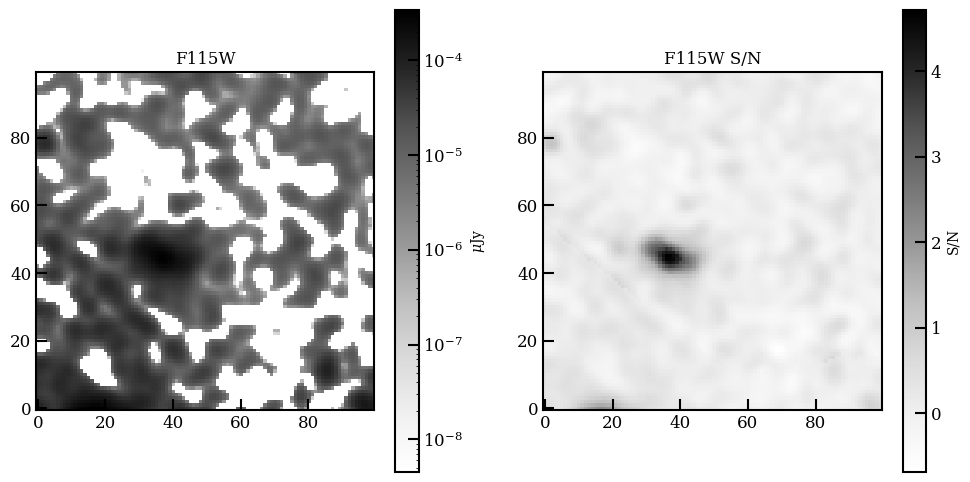

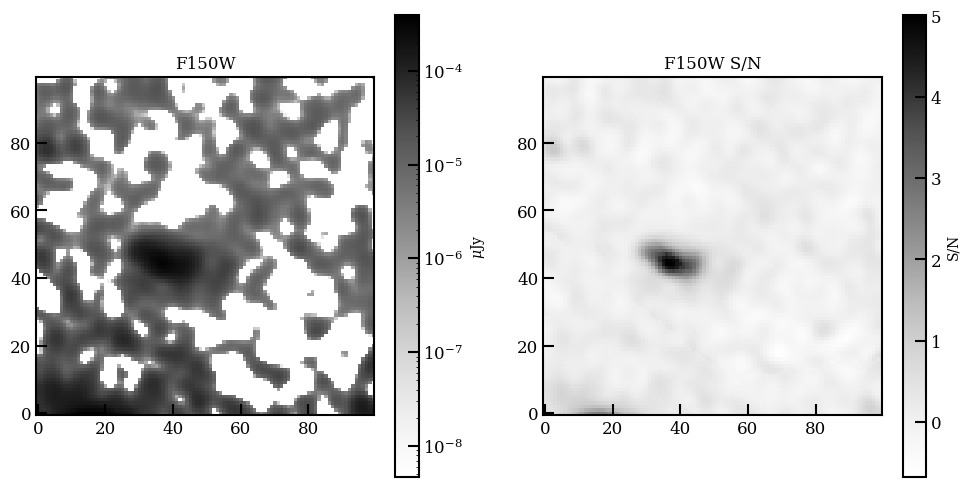

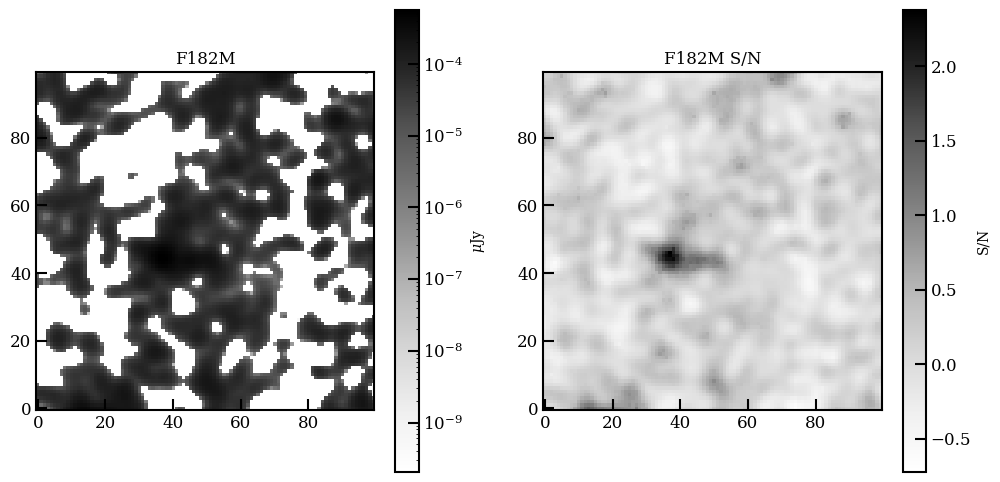

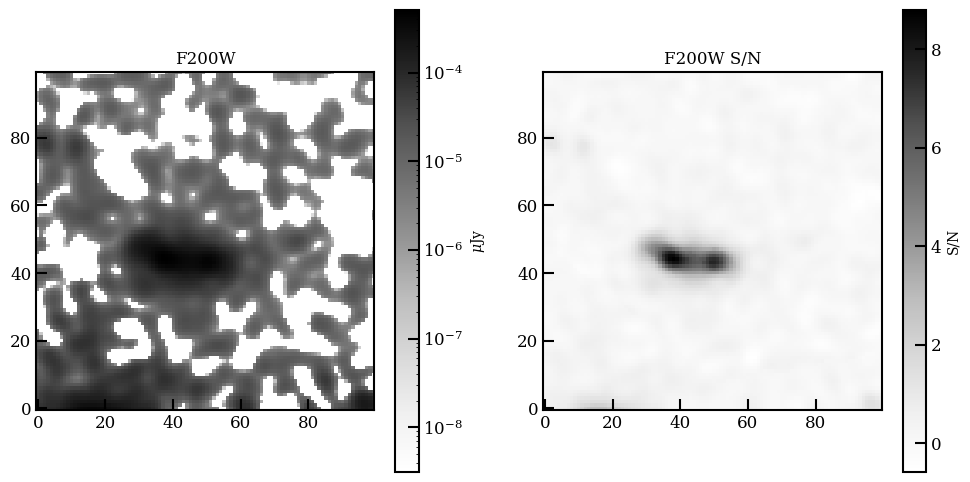

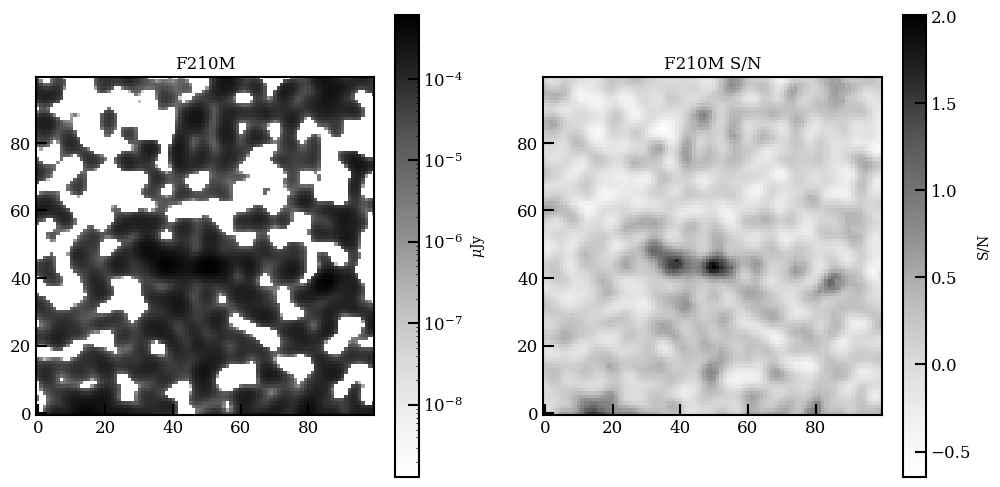

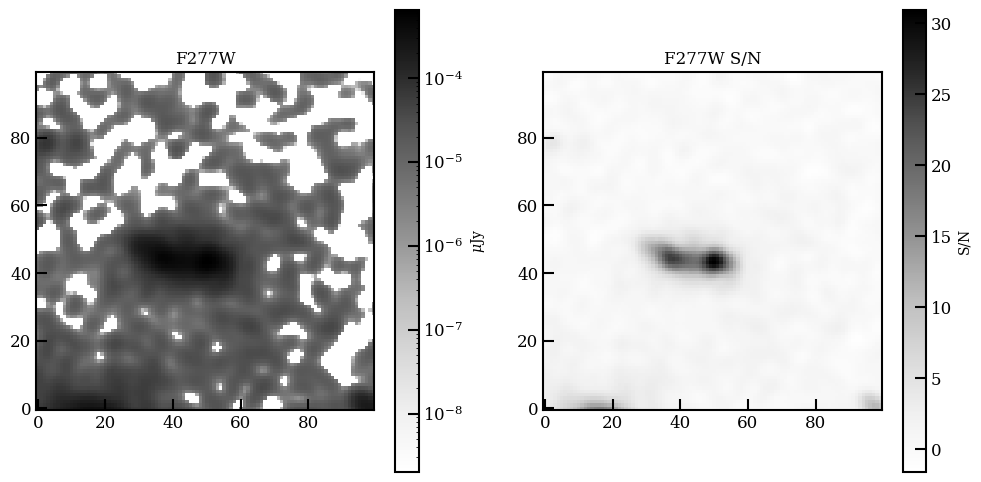

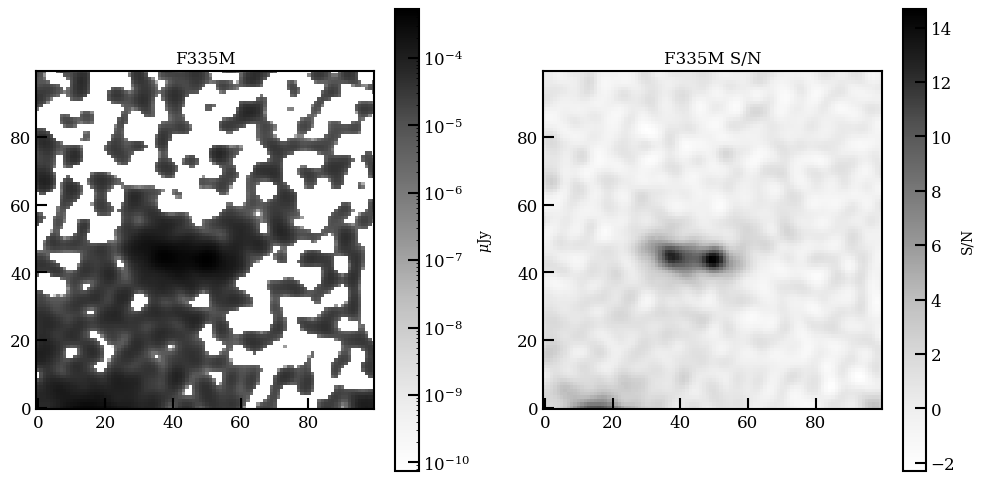

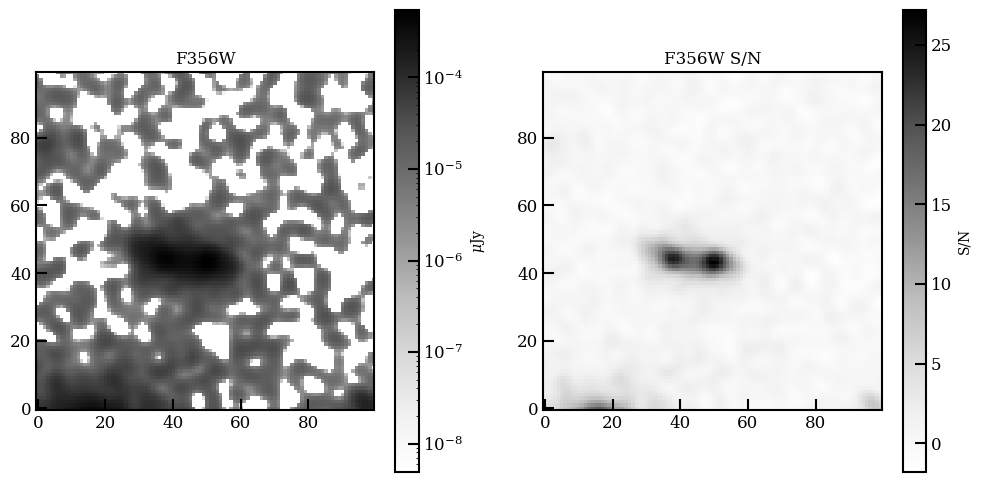

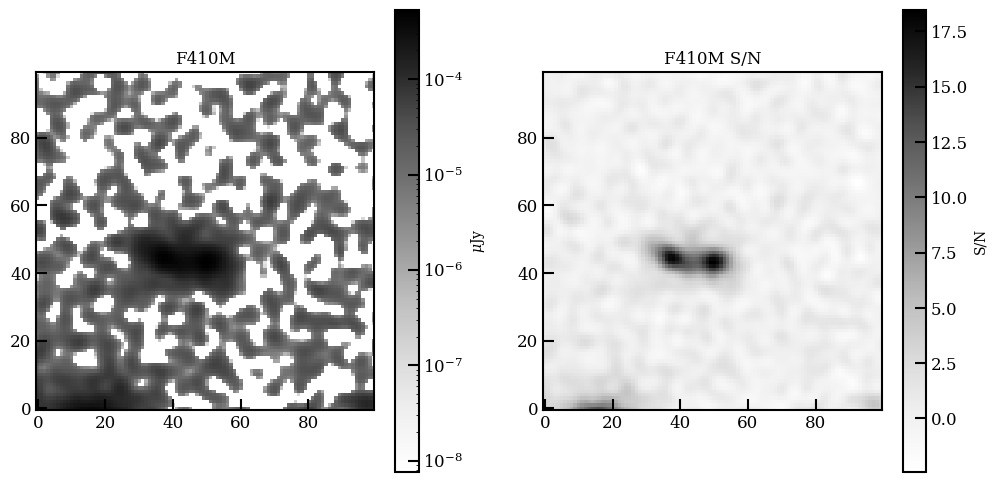

An error occurred when plotting the photometry for F430M, ignoring...


ValueError: Invalid vmin or vmax

<Figure size 1200x600 with 3 Axes>

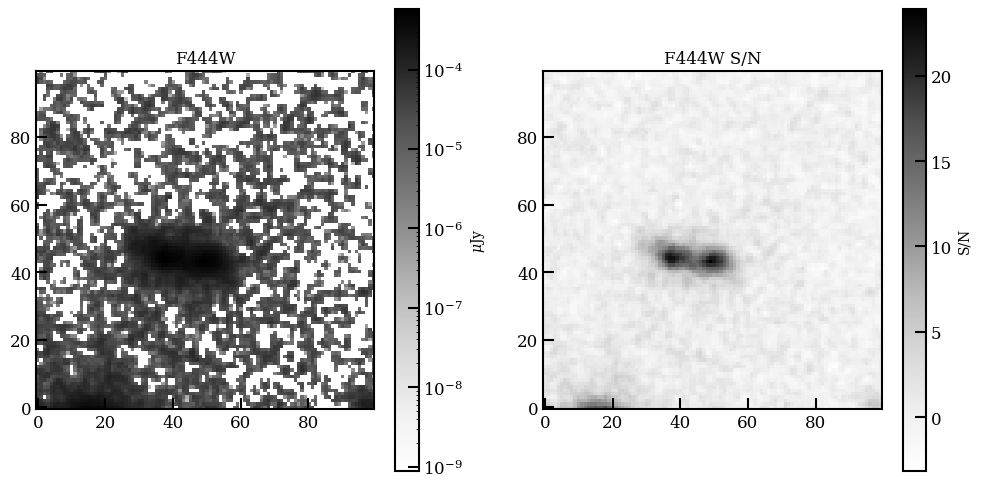

An error occurred when plotting the photometry for F460M, ignoring...
An error occurred when plotting the photometry for F480M, ignoring...


ValueError: Invalid vmin or vmax

<Figure size 1200x600 with 3 Axes>

ValueError: Invalid vmin or vmax

<Figure size 1200x600 with 3 Axes>

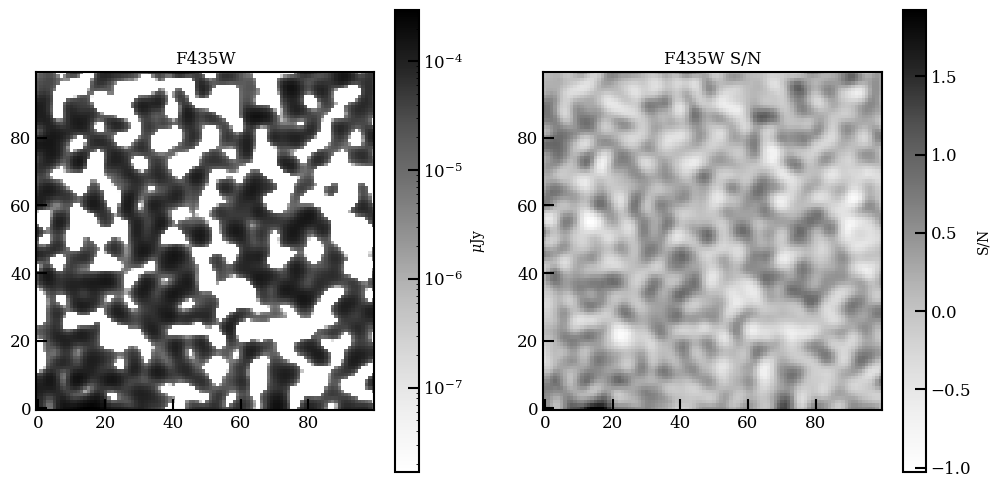

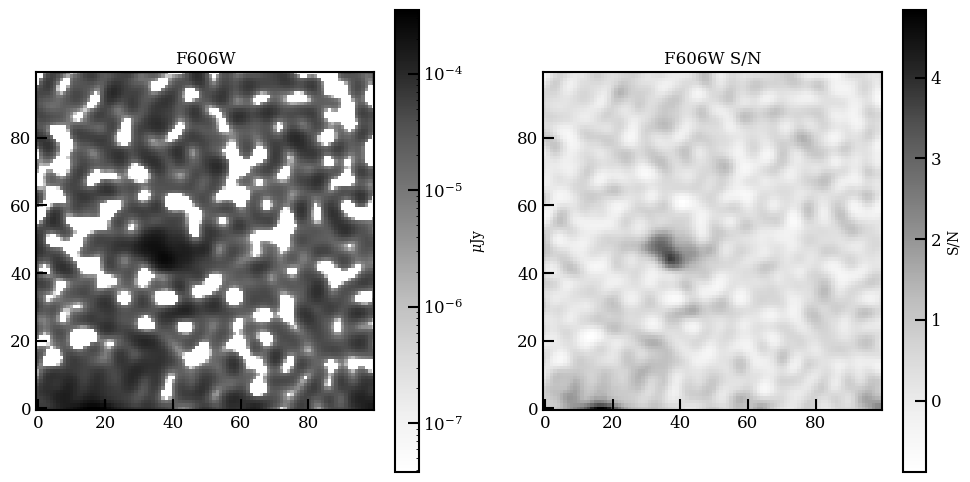

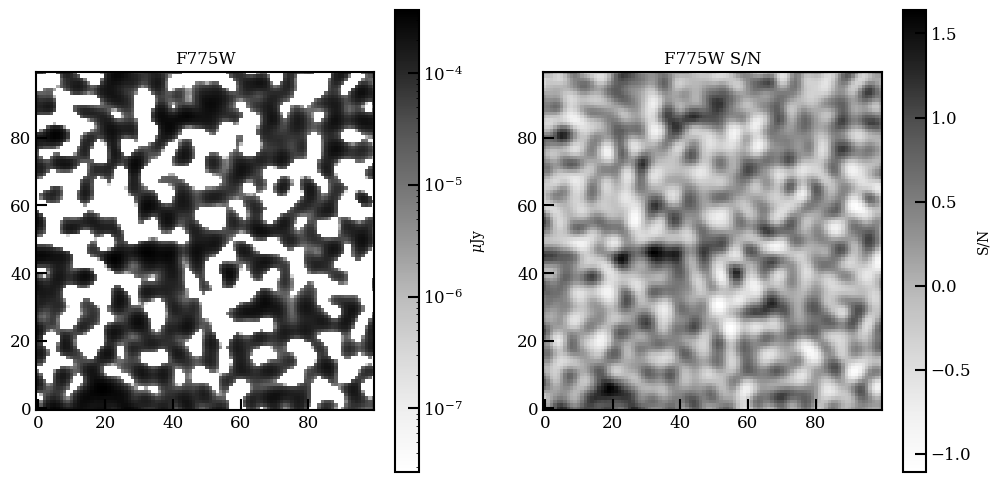

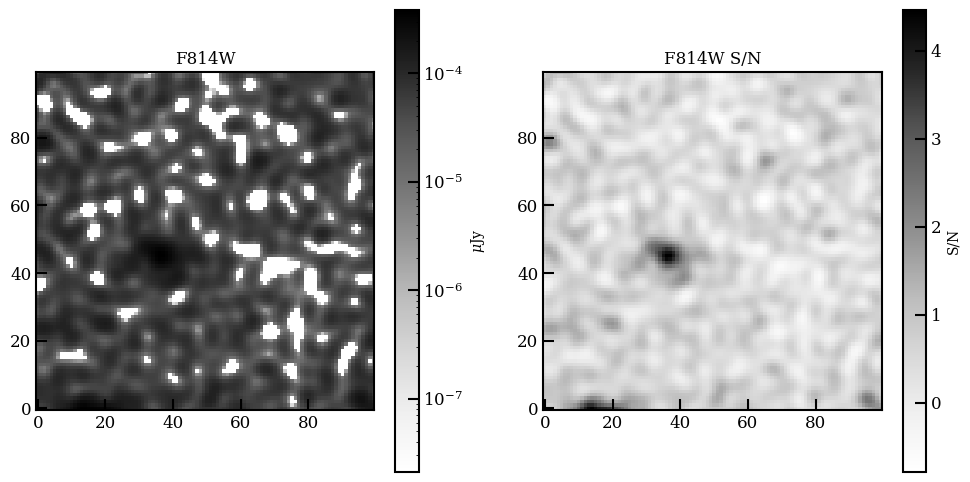

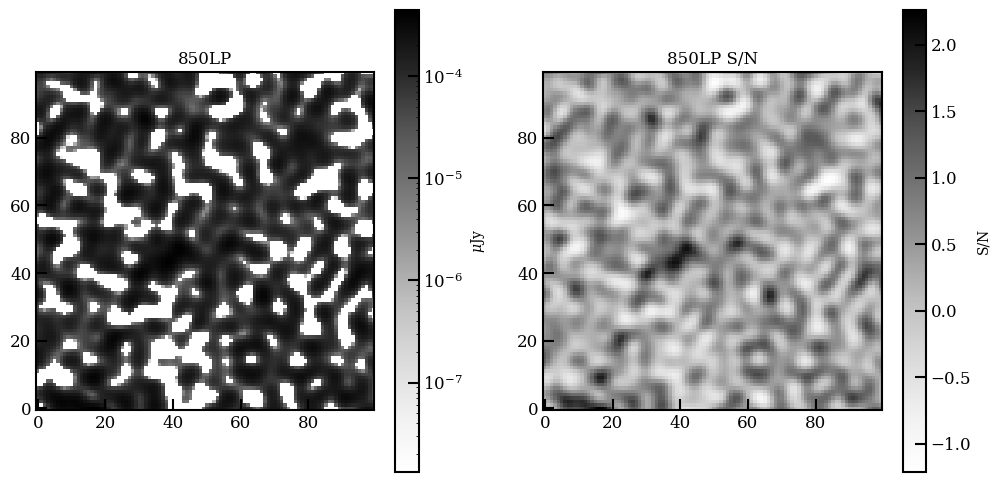

In [88]:
plot_photerr(phot_gal, err_gal)

### Compute inference per pixel

In [89]:
print("Computing resolved posteriors...")
p = sx.get_posteriors_resolved(
    phot_arr=phot[max_sn[:], :], 
    n_gal=1,
    n_samples=500, 
    sigma_arr=err[max_sn[:], :])


Computing resolved posteriors...


100%|██████████| 300/300 [00:01<00:00, 160.27it/s]


#### Plot parameter map for redshift

In [99]:
def plot_theta_z(n_theta=1, phot_gal=phot_gal, c_gal=c_gal, max_sn=max_sn, p=p, box=[0, phot_gal.shape[1], 0, phot_gal.shape[2]]):
    '''
    Plot parameter map for redshift

    Inputs:
        n_theta: number of parameters to plot (default is 1 for redshift)
        phot_gal: 3D array of photometry cutout (from cut_phot) [filters, y, x]
        c_gal: array of coordinates for the cutout [pixel][y,x]]
        max_sn: mask of pixels above the SNR limit
        p: posterior samples for the galaxy [full posterior per pixel, means, stds, modes]
        box: bounds for the cutout to display [y_start, y_end, x_start, x_end], can determine from plotting whole cutout first

    Outputs:
        None, but displays a plot of the redshift parameter map
    '''

    # Create an empty array to store the parameter values for the cutout, initialized with NaNs
    theta_gal = np.full((n_theta, phot_gal.shape[1], phot_gal.shape[2]), np.nan)
    print(theta_gal.shape)

    # For each pixel (these are post-SNR cut), grab coordinate from c_gal and compute the mean of the parameter (e.g., redshift) across the posterior samples
    # Store the mean value in the theta_gal array at the corresponding pixel coordinates
    for k in range(len(p[0])):
        if k < len(max_sn):
            pixel_idx = max_sn[k]
            if pixel_idx < len(c_gal):
                x, y = c_gal[pixel_idx]
                
                t = np.mean(p[0][k, :, 0], axis=0)

                theta_gal[:, x, y] = t

    fig, ax = plt.subplots(figsize=(6, 8))

    im = ax.imshow(theta_gal[0, box[0]:box[1], box[2]:box[3]], origin='lower', cmap='jet')
    cbar = plt.colorbar(mappable=im, label='z', location='top', ax=ax)

    plt.show()

    return theta_gal


(1, 110, 195)


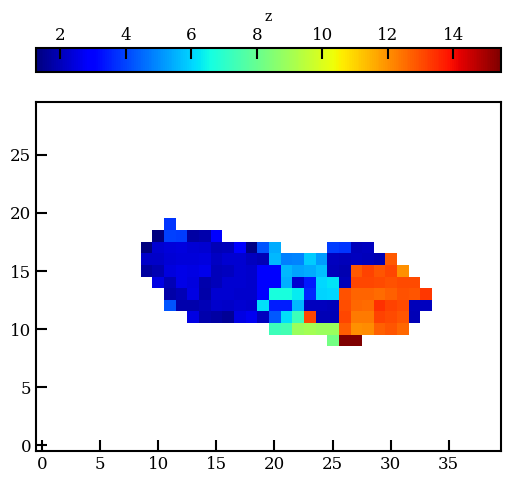

In [100]:
theta_gal = plot_theta_z(box=[35, 65, 70, 110])

### Pixel binning procedure

In [111]:
gal_region = np.where(np.isnan(theta_gal[0, :, :]), 0, 1)
n_theta = 0
pix_check_limit = 0.5

In [109]:
theta_gal_trans = np.transpose(theta_gal, (1, 2, 0))

dim_y = gal_region.shape[0]
dim_x = gal_region.shape[1]

pixbin_map = np.zeros((dim_y, dim_x))
map_bin_z = np.zeros((dim_y, dim_x, n_theta))

rows, cols = np.where((gal_region == 1) & (pixbin_map == 0))
tot_npixs = len(rows)


In [ ]:
Dmin_bin = 4.0
del_r = 2.0

count_bin = 0
cumul_npixs_in_bin = 0

while len(rows)>0:
    idx = np.unravel_index(theta_gal[0][rows, cols].argmax(), theta_gal[0][rows, cols].shape)
    bin_y_cent, bin_x_cent = rows[idx[0]], cols[idx[0]]

    bin_rad = 0.5*Dmin_bin
    del_dim = bin_rad + 3
    xmin = int(bin_x_cent - del_dim)
    xmax = int(bin_x_cent + del_dim)
    ymin = int(bin_y_cent - del_dim)
    ymax = int(bin_y_cent + del_dim)

    if xmin < 0:
        xmin = 0
    if xmax >= dim_x:
        xmax = dim_x - 1
    if ymin < 0:
        ymin = 0
    if ymax >= dim_y:
        ymax = dim_y - 1
    
    x = np.linspace(xmin, xmax, xmax - xmin + 1)
    y = np.linspace(ymin, ymax, ymax - ymin + 1)
    xx, yy = np.meshgrid(x, y)

    crop_gal_region = gal_region[ymin:ymax+1, xmin:xmax+1]
    crop_pixbin_map = pixbin_map[ymin:ymax+1, xmin:xmax+1]
  
    data2D_rad = np.sqrt(np.square(xx - bin_x_cent) + np.square(yy - bin_y_cent))   
    rows1, cols2 = np.where((data2D_rad <= bin_rad) & (crop_gal_region == 1) & (crop_pixbin_map == 0))  

    rows1 = rows1 + ymin
    cols1 = cols1 + xmin

    # would include something about characterizing whether this bin (before adding any more pixels) already satisfies the redshift constraint criteria
    # placeholder condition here:
    sat_condition = False

    if sat_condition == True:
        # do stuff to terminate building bin
        placeholder = 0

    else:
        stat_increase = 1
        cumul_rows = rows1.tolist()
        cumul_cols = cols1.tolist()

        while stat_increase == 1:
            rmin = bin_rad
            rmax = rmin + del_r

            del_dim = rmax + 3
            xmin = int(bin_x_cent - del_dim)
            xmax = int(bin_x_cent + del_dim)
            ymin = int(bin_y_cent - del_dim)
            ymax = int(bin_y_cent + del_dim)

            if xmin < 0:
                xmin = 0
            if xmax >= dim_x:
                xmax = dim_x - 1
            if ymin < 0:
                ymin = 0
            if ymax >= dim_y:
                ymax = dim_y - 1
            
            x = np.linspace(xmin, xmax, xmax - xmin + 1)
            y = np.linspace(ymin, ymax, ymax - ymin + 1)
            xx, yy = np.meshgrid(x, y)
        
            crop_gal_region = gal_region[ymin:ymax+1, xmin:xmax+1]
            crop_pixbin_map = pixbin_map[ymin:ymax+1, xmin:xmax+1]

            data2D_rad = np.sqrt(np.square(xx - bin_x_cent) + np.square(yy - bin_y_cent))
            rows1, cols1 = np.where((data2D_rad > rmin) & (data2D_rad <= rmax) & (crop_gal_region == 1) & (crop_pixbin_map == 0))   

            rows1 = rows1 + ymin
            cols1 = cols1 + xmin

            cent_pix_z_sim = np.zeros((dim_y, dim_x, n_theta))
            cent_pix_z_sim[rows1, cols1] = theta_gal_trans[bin_y_cent][bin_x_cent]

            pix_check = cent_pix_z_sim[rows1, cols1]/(1 + cent_pix_z_sim[rows1, cols1])

            idx_sel = np.where(pix_check < pix_check_limit)

            rows1_cut = rows[idx_sel[0]]
            cols1_cut = cols[idx_sel[0]]    

            cumul_rows = cumul_rows + rows1_cut.tolist()
            cumul_cols = cumul_cols + cols1_cut.tolist()    

            # rest I think depends on how I decide to definine finishing building a bin
    

Extra stuff

In [ ]:
def plot_parameter_maps_nataliav(posteriors=p[0], max_sn=max_sn, coordinates=c_gal, labels=['z'], phot_gal=phot_gal, 
                       ranges=[16054, 16249, 10684, 10794], metric='mean', cmap='viridis', savefig=False, galaxy_id=1, 
                       output_dir='', plot_fraction=False, psf_fwhm=5.36, sx=sx, filters=filters_name, 
                       f444w_idx=11):
    """Plot parameter maps from posteriors"""
    
    n_theta = 1
    theta_gal = np.full((n_theta, phot_gal.shape[1], phot_gal.shape[2]), np.nan)
    print(theta_gal.shape)
    
    # Fill parameter maps
    for k in range(len(posteriors)):
        if k < len(max_sn):
            pixel_idx = max_sn[k]
            if pixel_idx < len(coordinates):
                x, y = coordinates[pixel_idx]
                
                p = posteriors[k, :, :]
                
                if metric == 'mean':
                    t = np.mean(p, axis=0)
                elif metric == 'median':
                    t = np.median(p, axis=0)
                elif metric == 'mode':
                    t = stats.mode(np.around(p, 1), axis=0, keepdims=False)[0]
                elif metric == 'std':
                    t = np.std(p, axis=0)
                
                theta_gal[:, x, y] = t
    
    # Calculate fraction of fitted pixels
    total_pixels = len(coordinates)
    fitted_pixels = len(max_sn)
    ratio = fitted_pixels / total_pixels if total_pixels > 0 else 0
    print(f'Fitted pixels: {fitted_pixels}/{total_pixels} ({ratio:.2%})')
    
    # Set NaN for photometry where no parameters fitted
    nan_mask = np.isnan(theta_gal[0, :, :])
    print(len(theta_gal[0, nan_mask]))
    phot_gal[:, nan_mask] = np.nan
    
    # Plot F444W with overlays first
    fig, ax = plt.subplots(figsize=(6, 8))
    phot_slice = phot_gal[f444w_idx, ranges[0]:ranges[1], ranges[2]:ranges[3]]
    
    if np.any(np.isfinite(phot_slice)):
        im = ax.imshow(phot_slice, origin='lower', norm='log', cmap=cmap)
        filter_name = filters[f444w_idx].split('_')[-1] if '_' in filters[f444w_idx] else filters[f444w_idx]
        cbar = plt.colorbar(mappable=im, label=f'Flux in {filter_name} [μJy]', 
                          location='top', ax=ax)
        cbar.ax.tick_params(labelsize=16)
    
    # Add PSF circle if requested
    if psf_fwhm is not None:
        center_x, center_y = (10794-10684)//2, (16249-16054)//2#size//4, size//4  # Bottom left corner
        circle = patches.Circle((center_x, center_y), radius=psf_fwhm/2, 
                              edgecolor='black', facecolor='black', linewidth=2)
        ax.add_patch(circle)
        ax.text(center_x, center_y - psf_fwhm, 'PSF', ha='center', va='top', 
               fontsize=14, color='black')
    
    # Add fitted pixel fraction if requested
    if plot_fraction:
        ax.text(0.05, 0.95, f'Fitted: {ratio:.1%}', fontsize=16, 
               transform=ax.transAxes, color='white', 
               bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title(f'Galaxy {galaxy_id} - {filter_name}', fontsize=16)
    
    if savefig:
        plt.savefig(f'{output_dir}/{galaxy_id}/ID_{galaxy_id}_{filter_name}_reference.pdf', 
                   bbox_inches='tight')
    plt.show()
    
    # Plot parameter maps
    for i in range(n_theta):
        fig, ax = plt.subplots(figsize=(6, 8))
        
        param_slice = theta_gal[i, ranges[0]:ranges[1], ranges[2]:ranges[3]]
        print(param_slice.shape)
        
        # Handle reversed colormaps for certain parameters
        if sx.both_masses:
            reverse_params = [2, 3, 4]  # SFR, age-related parameters
        else:
            reverse_params = [1, 2, 3]
        
        cmap_use = cmap + '_r' if i in reverse_params else cmap
        
        if np.any(np.isfinite(param_slice)):
            im = ax.imshow(param_slice, origin='lower', cmap=cmap_use)
            
            # Add total stellar mass annotation for mass parameter
            if i == 0 and 'log(M' in labels[i]:
                total_mass = np.log10(np.nansum(10 ** theta_gal[i, :, :]))
                ax.text(0.05, 0.05, f'log(M*,tot/M☉) = {total_mass:.2f}', 
                       fontsize=16, transform=ax.transAxes, color='white',
                       bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
            
            cbar = plt.colorbar(mappable=im, label=labels[i], location='top', ax=ax)
            cbar.ax.tick_params(labelsize=16)
        else:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=16)
        
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_title(f'Galaxy {galaxy_id} - {labels[i]}', fontsize=16)
        
        if savefig:
            plt.savefig(f'{output_dir}/{galaxy_id}/ID_{galaxy_id}_param_{i}_{labels[i].replace("/", "_")}.pdf', 
                       bbox_inches='tight')
        plt.show()